In [ ]:
!pip install tensorflow

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from scipy.linalg import eigh_tridiagonal

#Creamos una semilla que asegurará que las variables pseudoaleatorias sean constantes entre intentos
seed = 128
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

# Probando No-Linealidades


## Fracción


In [ ]:
num_domain = 30
minval = 0
maxval = 2

def generate_uniform_data(num_domain, minval, maxval):
  data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=seed)
  return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)

x = generate_uniform_data(num_domain, minval, maxval)

In [ ]:
def pde(tape1, x, y, j=0):
  dy_x = tape1.gradient(y, x)[:, j : j + 1]
  return dy_x + y*y

def ic_0(x):

  return 1/2

x_0 = tf.Variable([[0]], shape=[1, 1], dtype=tf.float32)

In [ ]:
n_inputs = 1
n_outputs = 1
activation = 'tanh'

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((n_inputs,)))
model.add(tf.keras.layers.Dense(units=4, activation=activation))
model.add(tf.keras.layers.Dense(units=7, activation=activation))
model.add(tf.keras.layers.Dense(units=n_outputs))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51 (204.00 B)

 Trainable params: 51 (204.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 1200
learning_rate = 0.01

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

flag = False
previous_mse = 0
diff_tolerance = 0.00003
tolerance = 0.0003
max_count = 5
count = 0

error_arr = np.zeros(epochs//20 + 1)
epoch_arr = np.linspace(0, epochs, epochs//20 + 1)

while not flag:
  for i in range(epochs + 1):
    with tf.GradientTape() as tape_model:

      y_0 = model(x_0, training=True)

      ic_error = abs(model(x_0, training=True)[0][0] - ic_0(x_0))



      with tf.GradientTape() as tape_pde:

        y = model(x, training=True)

        domain_error = pde(tape_pde, x, y)




      domain_mse = mse = tf.math.reduce_mean(tf.math.square(domain_error), axis=0)
      ic_mse =  tf.math.square(ic_error)
      total_mse = domain_mse + 20*ic_mse


      if i % 100 == 0:
        print('Epoch: {}\t Total Loss = {}'.format(i, total_mse.numpy()[0]))
        print('Domain Loss = {}'.format(domain_mse.numpy()[0]))
        print('Initial Condition Loss = {}'.format(20*ic_mse.numpy()))

      if i % 20 == 0:

        error_arr[i//20] = total_mse.numpy()[0]




    if abs(domain_mse - previous_mse) < diff_tolerance and domain_mse < tolerance:

      count += 1

      if count >= max_count:

        max_epoch = i

        flag = True
        break


    else:

      count = 0

    if i == epochs:

      max_epoch = i

      flag = True
      break

    previous_mse = domain_mse

    model_update_gradients = tape_model.gradient(total_mse, model.trainable_variables)
    optimizer.apply_gradients(
    zip(model_update_gradients, model.trainable_variables)
    )

Epoch: 0	 Total Loss = 5.036674499511719
Domain Loss = 0.03667467087507248
Initial Condition Loss = 5.0
Epoch: 100	 Total Loss = 0.0005868584266863763
Domain Loss = 0.0005758253391832113
Initial Condition Loss = 1.1033061127818655e-05
Epoch: 200	 Total Loss = 0.0004816372529603541
Domain Loss = 0.0004814911517314613
Initial Condition Loss = 1.4611288179366966e-07
Epoch: 300	 Total Loss = 0.00039836385985836387
Domain Loss = 0.0003982169437222183
Initial Condition Loss = 1.4692915328851086e-07
Epoch: 400	 Total Loss = 0.0003139405744150281
Domain Loss = 0.00031382543966174126
Initial Condition Loss = 1.1514551090385794e-07


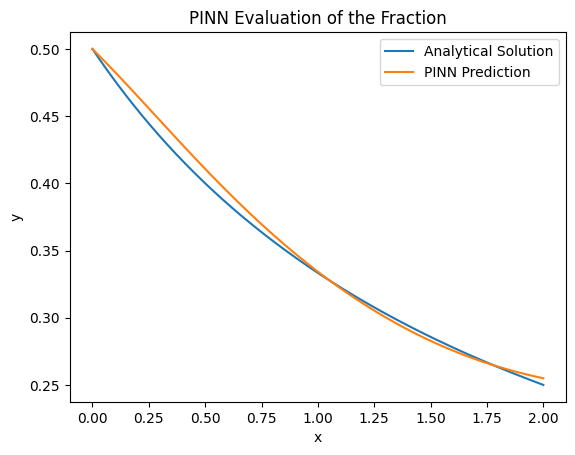

In [ ]:
x_test = np.linspace(0, 2, 300)
y_true = 1/(x_test+2)
y_pred = model(x_test)

plt.plot(x_test, y_true)
plt.plot(x_test, y_pred)
plt.title('PINN Evaluation of the Fraction')
plt.legend(['Analytical Solution', 'PINN Prediction'])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

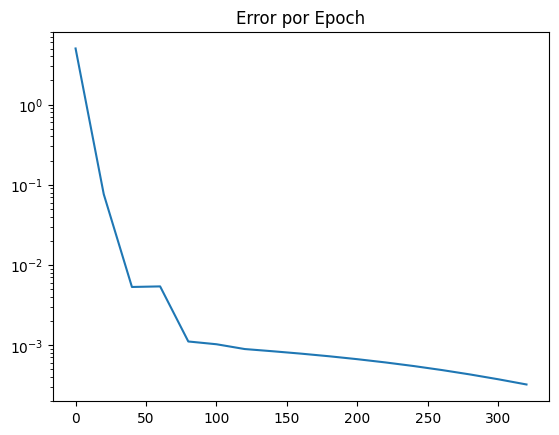

In [ ]:
plt.semilogy(epoch_arr[:max_epoch//20+1], error_arr[:max_epoch//20+1])
plt.title('Error por Epoch')
plt.show()

In [ ]:
val_error = 0
for i in range(len(y_pred)):

  val_error += (y_pred[i] - y_true[i])**2

val_error = val_error/len(y_pred)
val_error

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.784585e-05], dtype=float32)>

### Montecarlo

Model: "sequential_215"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_652 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_653 (Dense)               │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_654 (Dense)               │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27 (108.00 B)

 Trainable params: 27 (108.00 B)

 Non-trainable params: 0 (0.00 B)

Montecarlo: 1	 Starting MSE Loss = 5.05446720123291
Montecarlo: 1	 Final Epoch = 97	 Final MSE Loss = 0.0001557282084831968
Execution time of NN number 1:  6.341118574142456
Test MSE Loss = 2.0965833755326457e-05
Montecarlo: 2	 Starting MSE Loss = 5.606429100036621
Montecarlo: 2	 Final Epoch = 399	 Final MSE Loss = 0.00029548033489845693
Execution time of NN number 2:  19.998047590255737
Test MSE Loss = 5.631157546304166e-05
Montecarlo: 3	 Starting MSE Loss = 5.003737926483154
Montecarlo: 3	 Final Epoch = 98	 Final MSE Loss = 0.00022683954739477485
Execution time of NN number 3:  5.474220037460327
Test MSE Loss = 3.3353939215885475e-05
Montecarlo: 4	 Starting MSE Loss = 5.1567912101745605
Montecarlo: 4	 Final Epoch = 1200	 Final MSE Loss = 0.0004529610450845212
Execution time of NN number 4:  61.869999170303345
Test MSE Loss = 6.507436773972586e-05
Montecarlo: 5	 Starting MSE Loss = 5.376556873321533
Montecarlo: 5	 Final Epoch = 1200	 Final MSE Loss = 0.00046213038149289787
Execution t

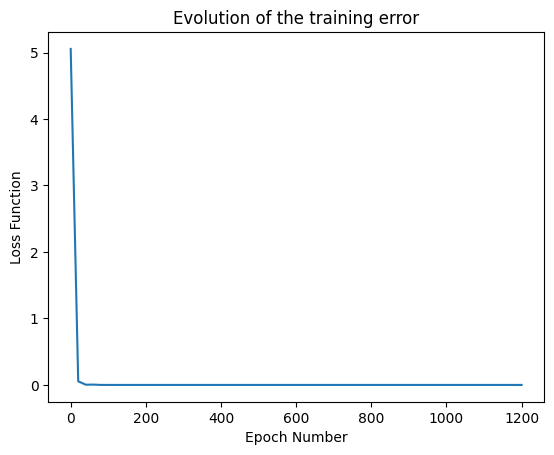

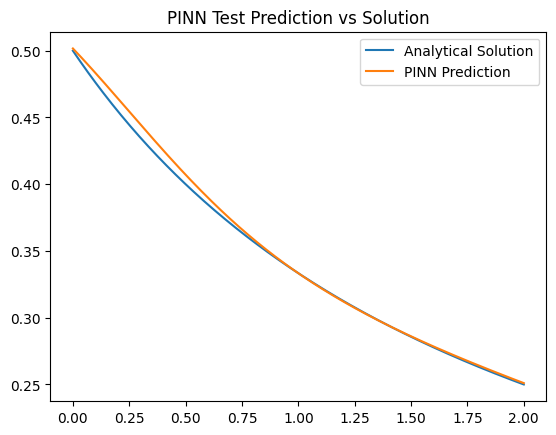

In [ ]:
import numpy as np

def paralel_montecarlo_piqnn_frac(j,max_epochs=10000, seed=128):

    import os

    #Usamos el Keras 2.x, ya que es el único compatible con qml.qnn.KerasLayer

    os.environ["TF_USE_LEGACY_KERAS"] = "1"

    import numpy as np
    import tensorflow as tf
    import matplotlib.pyplot as plt
    import time


    #Evitamos warnings sobre el cast complex a float

    tf.get_logger().setLevel('ERROR')

    #Forzamos a Tensorflow a trabajar con "float64" (desactivado)

    #tf.keras.backend.set_floatx('float64')


    num_domain = 30
    minval = 0
    maxval = 2

    def generate_uniform_data(num_domain, minval, maxval):
      data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=seed)
      return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)

    x = generate_uniform_data(num_domain, minval, maxval)

    ###

    def pde(tape1, x, y, j=0):
      dy_x = tape1.gradient(y, x)[:, j : j + 1]
      return dy_x + y*y

    def ic_0(x):

      return 1/2

    def ic_0_d(x):

      return 0


    x_0 = tf.Variable([[0]], shape=[1, 1], dtype=tf.float32)


    ###

    n_inputs = 1
    n_outputs = 1
    activation = 'tanh'

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((n_inputs,)))
    model.add(tf.keras.layers.Dense(units=4, activation=activation))
    model.add(tf.keras.layers.Dense(units=3, activation=activation))
    model.add(tf.keras.layers.Dense(units=n_outputs))

    if j==0:

      model.summary()


    epochs = max_epochs
    learning_rate = 0.01

    flag = False
    previous_mse = 0
    diff_tolerance = 0.00003
    tolerance = 0.0003
    max_count = 5
    count = 0

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    error_arr = np.zeros(epochs//20 + 1)

    epoch_arr = np.linspace(0, epochs, epochs//20 + 1)

    while not flag:

      starting_time = time.time()

      for i in range(epochs + 1):


        with tf.GradientTape() as tape_model:

          ic_error = abs(model(x_0, training=True)[0][0] - ic_0(x_0))


          with tf.GradientTape() as tape_pde:
              y = model(x, training=True)

              domain_error = pde(tape_pde, x, y)

          domain_mse = mse = tf.math.reduce_mean(tf.math.square(domain_error), axis=0)
          ic_mse =  tf.math.square(ic_error)
          total_mse = domain_mse + 20*ic_mse

          #if i % 100 == 0:

            #print('Epoch: {}\t Total Loss = {}'.format(i, total_mse.numpy()[0]))
            #print('Domain Loss = {}'.format(domain_mse.numpy()[0]))
            #print('Initial and Periodical Condition Loss = {}'.format(20*ic_mse.numpy()))


          if i % 20 == 0:

            error_arr[i//20] = total_mse.numpy()[0]

          if i == 0:

            first_error = total_mse.numpy()[0]

            print('Montecarlo: {}\t Starting MSE Loss = {}'.format(j+1, first_error), flush=True)




        if abs(total_mse - previous_mse) < diff_tolerance and total_mse < tolerance:

          count += 1

          if count >= max_count:

            max_epoch = i
            last_error = total_mse.numpy()[0]


            print('Montecarlo: {}\t Final Epoch = {}\t Final MSE Loss = {}'.format(j+1, max_epoch, last_error), flush=True)

            flag = True
            break


        else:

          count = 0

        if i == epochs:

          max_epoch = i
          last_error = total_mse.numpy()[0]


          print('Montecarlo: {}\t Final Epoch = {}\t Final MSE Loss = {}'.format(j+1, max_epoch, last_error), flush=True)

          flag = True
          break

        previous_mse = total_mse

        model_update_gradients = tape_model.gradient(total_mse, model.trainable_variables)
        optimizer.apply_gradients(
        zip(model_update_gradients, model.trainable_variables)
        )

      ending_time = time.time()

      print(f"Execution time of NN number {j+1}: ", ending_time-starting_time, flush=True)

      x_test = np.linspace(0, 2, 300)

      y_pred = model(x_test)

      y_true = 1/(x_test + 2)

      val_error = 0
      for i in range(len(y_pred)):

        val_error += (y_pred[i] - y_true[i])**2

      val_error = val_error/len(y_pred)
      val_error = val_error[0]

      print('Test MSE Loss = {}'.format(val_error), flush=True)





    return error_arr, epoch_arr, [first_error, max_epoch, last_error, val_error], y_pred, y_true

first_error_arr = []
max_epoch_arr = []
last_error_arr = []
val_error_arr = []

for j in range(100):

  results = paralel_montecarlo_piqnn_frac(j,max_epochs=1200, seed=128)

  first_error_arr.append(results[2][0]), max_epoch_arr.append(results[2][1]), last_error_arr.append(results[2][2]), val_error_arr.append(results[2][3])

  if j==0:

    error_arr = results[0]
    epoch_arr = results[1]
    y_pred = results[3]
    y_true = results[4]

print(f"""
Mean starting error: {np.array(first_error_arr).mean()}         Starting error Variance: {np.array(first_error_arr).var()}
Mean max epoch: {np.array(max_epoch_arr).mean()}                Max Epoch Variance: {np.array(max_epoch_arr).var()}
Mean final error: {np.array(last_error_arr).mean()}             Final error Variance: {np.array(last_error_arr).var()}
Mean validation error: {np.array(val_error_arr).mean()}         Validation error Variance: {np.array(val_error_arr).var()}
""")

plt.plot(epoch_arr, error_arr)
plt.title("Evolution of the training error")
plt.xlabel("Epoch Number")
plt.ylabel("Loss Function")
plt.show()

x_test = np.linspace(0, 2, 300)

plt.plot(x_test, y_true)
plt.plot(x_test, y_pred)
plt.title("PINN Test Prediction vs Solution")
plt.legend(["Analytical Solution", "PINN Prediction"])
plt.show()

## Péndulo

In [ ]:
num_domain = 64
minval = 0
maxval = 2.5

def generate_uniform_data(num_domain, minval, maxval):
  data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=seed)
  return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)

x = generate_uniform_data(num_domain, minval, maxval)
gamma = 1
g = 9.8
L = 1
w = np.sqrt(g/L)
T = 2*np.pi/w

In [ ]:
def pde(tape1, tape2, x, y, j=0):
  dy_x = tape1.gradient(y, x)[:, j : j + 1]
  dy_xx = tape2.gradient(dy_x, x)[:, j : j + 1]
  return dy_xx + g/L * tf.sin(y)

def ic_0(x):

  return np.pi/4

def ic_0_d(x):

  return 0

for i in range(int(maxval/T) + 1):

  vars()[f"x_{i}"] = tf.Variable([[i*T]], shape=[1, 1], dtype=tf.float32)

In [ ]:
n_inputs = 1
n_outputs = 1
activation = 'tanh'

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((n_inputs,)))
model.add(tf.keras.layers.Dense(units=4, activation=activation))
model.add(tf.keras.layers.Dense(units=4, activation=activation))
model.add(tf.keras.layers.Dense(units=7, activation=activation))
model.add(tf.keras.layers.Dense(units=n_outputs))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 2000
learning_rate = 0.02

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

flag = False
previous_mse = 0
diff_tolerance = 0.0003
tolerance = 0.003
max_count = 5
count = 0

error_arr = np.zeros(epochs//20 + 1)
epoch_arr = np.linspace(0, epochs, epochs//20 + 1)

while not flag:
  for i in range(epochs + 1):
    with tf.GradientTape() as tape_model:
      with tf.GradientTape() as tape_bc:

        y_0 = model(x_0, training=True)
        dy_0 = tape_bc.gradient(y_0, x_0)[0,0]
        ic2_error = dy_0 - ic_0_d(x_0)

        ic_error = abs(model(x_0, training=True)[0][0] - ic_0(x_0))



      with tf.GradientTape() as tape_pde:
        with tf.GradientTape() as tape_pde2:

          y = model(x, training=True)

          domain_error = pde(tape_pde, tape_pde2, x, y)


          #non_zero_loss = tf.math.exp(-tf.math.reduce_mean(y*y, axis=0))[0]
          #non_zero_loss = tf.math.exp(-(tf.tensordot(y[:,0],y[:,0],1)))

      #for j in range(int(maxval/T)):

        #ic_error += abs(model(vars()[f"x_{j+1}"], training=True)[0][0] - ic_0(vars()[f"x_{j+1}"]))


      domain_mse = mse = tf.math.reduce_mean(tf.math.square(domain_error), axis=0)
      ic_mse =  tf.math.square(ic_error)
      ic2_mse = tf.math.square(ic2_error)
      #non_zero_mse = tf.math.square(non_zero_loss)
      total_mse = domain_mse + 20*ic_mse + 20*ic2_mse
      #total_mse += non_zero_mse

      if i % 100 == 0:
        print('Epoch: {}\t Total Loss = {}'.format(i, total_mse.numpy()[0]))
        print('Domain Loss = {}'.format(domain_mse.numpy()[0]))
        print('Initial Condition Loss = {}'.format(20*ic_mse.numpy() + 20*ic2_mse.numpy()))
        #print('Non-Zero Loss = {}'.format(non_zero_mse.numpy()))


      if i % 20 == 0:

        error_arr[i//20] = total_mse.numpy()[0]




    if abs(domain_mse - previous_mse) < diff_tolerance and domain_mse < tolerance:

      count += 1

      if count >= max_count:

        max_epoch = i

        flag = True
        break


    else:

      count = 0

    if i == epochs:

      max_epoch = i

      flag = True
      break

    previous_mse = domain_mse

    model_update_gradients = tape_model.gradient(total_mse, model.trainable_variables)
    optimizer.apply_gradients(
    zip(model_update_gradients, model.trainable_variables)
    )

Epoch: 0	 Total Loss = 37.30979537963867
Domain Loss = 15.677705764770508
Initial Condition Loss = 21.632089614868164
Epoch: 100	 Total Loss = 2.928269147872925
Domain Loss = 2.176588535308838
Initial Condition Loss = 0.7516806721687317
Epoch: 200	 Total Loss = 1.863448977470398
Domain Loss = 1.601656436920166
Initial Condition Loss = 0.2617925703525543
Epoch: 300	 Total Loss = 1.748969316482544
Domain Loss = 1.5200204849243164
Initial Condition Loss = 0.22894889116287231
Epoch: 400	 Total Loss = 1.6968785524368286
Domain Loss = 1.4744012355804443
Initial Condition Loss = 0.22247736155986786
Epoch: 500	 Total Loss = 1.5662649869918823
Domain Loss = 1.3940160274505615
Initial Condition Loss = 0.17224891483783722
Epoch: 600	 Total Loss = 1.0695550441741943
Domain Loss = 0.9558159112930298
Initial Condition Loss = 0.11373911052942276
Epoch: 700	 Total Loss = 0.2471313327550888
Domain Loss = 0.23372675478458405
Initial Condition Loss = 0.013404583558440208
Epoch: 800	 Total Loss = 0.826447

tf.Tensor([0.00012575], shape=(1,), dtype=float32)


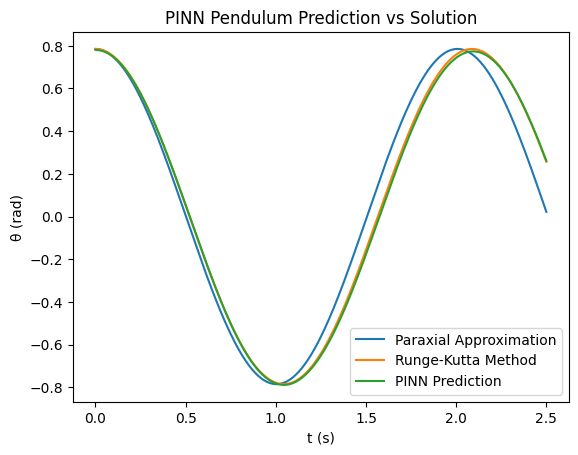

In [ ]:
x_test = np.linspace(0, 2.5, 300)
y_para = np.pi/4 * np.sin(w*x_test + np.pi/2)
y_pred = model(x_test)

# Parameters

theta0 = np.pi / 4  # Initial angle (rad)
omega0 = 0.0        # Initial angular velocity (rad/s)
t_0 = 0           # Start time (s)
t_f = 2.5           # End time (s)
dt = (t_f-t_0)/299           # Time step (s)

# Number of steps
n = int((t_f - t_0) / dt)

# Arrays to store results
t = np.linspace(t_0, t_f, n+1)
y_kutta = np.zeros(n+1)
omega = np.zeros(n+1)

# Initial conditions
y_kutta[0] = theta0
omega[0] = omega0

# Define the system of ODEs
def f_theta(y_kutta, omega):
    return omega

def f_omega(y_kutta, omega):
    return - (g / L) * np.sin(y_kutta)

# Runge-Kutta 4th Order Method
for i in range(n):
    k1_theta = dt * f_theta(y_kutta[i], omega[i])
    k1_omega = dt * f_omega(y_kutta[i], omega[i])

    k2_theta = dt * f_theta(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)
    k2_omega = dt * f_omega(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)

    k3_theta = dt * f_theta(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)
    k3_omega = dt * f_omega(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)

    k4_theta = dt * f_theta(y_kutta[i] + k3_theta, omega[i] + k3_omega)
    k4_omega = dt * f_omega(y_kutta[i] + k3_theta, omega[i] + k3_omega)

    y_kutta[i+1] = y_kutta[i] + (k1_theta + 2*k2_theta + 2*k3_theta + k4_theta) / 6
    omega[i+1] = omega[i] + (k1_omega + 2*k2_omega + 2*k3_omega + k4_omega) / 6

val_error = 0
for i in range(len(y_pred)):

  val_error += (y_pred[i] - y_kutta[i])**2

val_error = val_error/len(y_pred)

print(val_error)

plt.plot(x_test, y_para)
plt.plot(x_test, y_kutta)
plt.plot(x_test, y_pred)
plt.title('PINN Pendulum Prediction vs Solution')
plt.legend(['Paraxial Approximation', 'Runge-Kutta Method', 'PINN Prediction'])
plt.xlabel("t (s)")
plt.ylabel("θ (rad)")
plt.show()

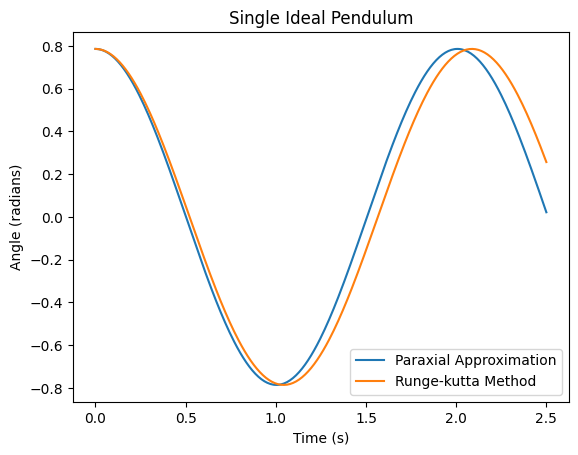

In [ ]:
x_test = np.linspace(0, 2.5, 300)
y_para = np.pi/4 * np.sin(w*x_test + np.pi/2)

# Parameters

theta0 = np.pi / 4  # Initial angle (rad)
omega0 = 0.0        # Initial angular velocity (rad/s)
t_0 = 0           # Start time (s)
t_f = 2.5           # End time (s)
dt = (t_f-t_0)/299           # Time step (s)

# Number of steps
n = int((t_f - t_0) / dt)

# Arrays to store results
t = np.linspace(t_0, t_f, n+1)
y_kutta = np.zeros(n+1)
omega = np.zeros(n+1)

# Initial conditions
y_kutta[0] = theta0
omega[0] = omega0

# Define the system of ODEs
def f_theta(y_kutta, omega):
    return omega

def f_omega(y_kutta, omega):
    return - (g / L) * np.sin(y_kutta)

# Runge-Kutta 4th Order Method
for i in range(n):
    k1_theta = dt * f_theta(y_kutta[i], omega[i])
    k1_omega = dt * f_omega(y_kutta[i], omega[i])

    k2_theta = dt * f_theta(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)
    k2_omega = dt * f_omega(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)

    k3_theta = dt * f_theta(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)
    k3_omega = dt * f_omega(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)

    k4_theta = dt * f_theta(y_kutta[i] + k3_theta, omega[i] + k3_omega)
    k4_omega = dt * f_omega(y_kutta[i] + k3_theta, omega[i] + k3_omega)

    y_kutta[i+1] = y_kutta[i] + (k1_theta + 2*k2_theta + 2*k3_theta + k4_theta) / 6
    omega[i+1] = omega[i] + (k1_omega + 2*k2_omega + 2*k3_omega + k4_omega) / 6

plt.plot(x_test, y_para)
plt.plot(x_test, y_kutta)
plt.xlabel("Time (s)")
plt.ylabel("Angle (radians)")
plt.title('Single Ideal Pendulum')
plt.legend(['Paraxial Approximation', 'Runge-kutta Method'])
plt.show()

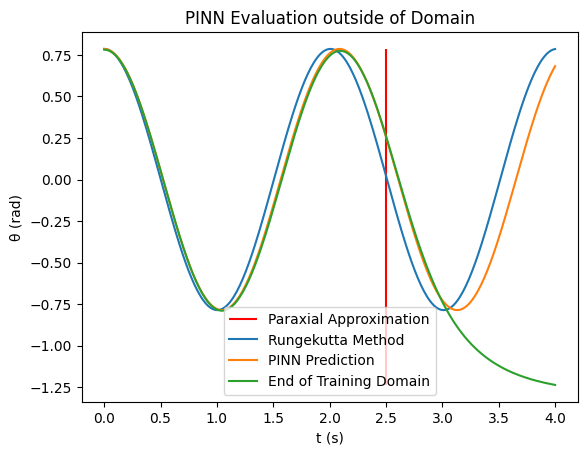

In [ ]:
x_test = np.linspace(0, 4, 300)
y_para = np.pi/4 * np.sin(w*x_test + np.pi/2)
y_pred = model(x_test)

plt.vlines(2.5, min(min(y_para), min(y_pred)), max(max(y_para), max(y_pred)), colors="r")

# Parameters

theta0 = np.pi / 4  # Initial angle (rad)
omega0 = 0.0        # Initial angular velocity (rad/s)
t_0 = 0           # Start time (s)
t_f = 4           # End time (s)
dt = (t_f-t_0)/299           # Time step (s)

# Number of steps
n = int((t_f - t_0) / dt)

# Arrays to store results
t = np.linspace(t_0, t_f, n+1)
y_kutta = np.zeros(n+1)
omega = np.zeros(n+1)

# Initial conditions
y_kutta[0] = theta0
omega[0] = omega0

# Define the system of ODEs
def f_theta(y_kutta, omega):
    return omega

def f_omega(y_kutta, omega):
    return - (g / L) * np.sin(y_kutta)

# Runge-Kutta 4th Order Method
for i in range(n):
    k1_theta = dt * f_theta(y_kutta[i], omega[i])
    k1_omega = dt * f_omega(y_kutta[i], omega[i])

    k2_theta = dt * f_theta(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)
    k2_omega = dt * f_omega(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)

    k3_theta = dt * f_theta(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)
    k3_omega = dt * f_omega(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)

    k4_theta = dt * f_theta(y_kutta[i] + k3_theta, omega[i] + k3_omega)
    k4_omega = dt * f_omega(y_kutta[i] + k3_theta, omega[i] + k3_omega)

    y_kutta[i+1] = y_kutta[i] + (k1_theta + 2*k2_theta + 2*k3_theta + k4_theta) / 6
    omega[i+1] = omega[i] + (k1_omega + 2*k2_omega + 2*k3_omega + k4_omega) / 6

plt.plot(x_test, y_para)
plt.plot(x_test, y_kutta)
plt.plot(x_test, y_pred)
plt.title('PINN Evaluation outside of Domain')
plt.legend(['Paraxial Approximation', 'Rungekutta Method', 'PINN Prediction', 'End of Training Domain'])
plt.xlabel("t (s)")
plt.ylabel("θ (rad)")
plt.show()

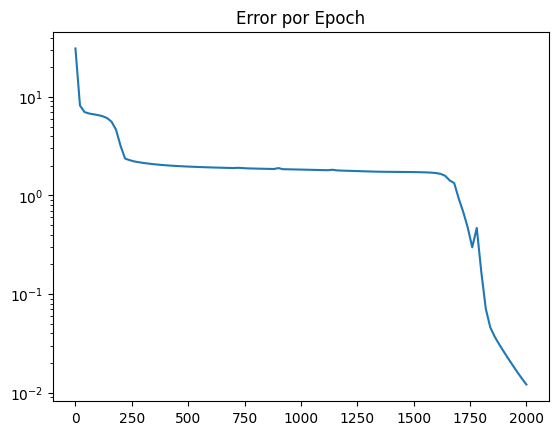

In [ ]:
plt.semilogy(epoch_arr[:max_epoch//20+1], error_arr[:max_epoch//20+1])
plt.title('Error por Epoch')
plt.show()

### Montecarlo

In [ ]:
import numpy as np

def paralel_montecarlo_piqnn_pendulum(j,max_epochs=10000, seed=128):

    import os

    #Usamos el Keras 2.x, ya que es el único compatible con qml.qnn.KerasLayer

    os.environ["TF_USE_LEGACY_KERAS"] = "1"

    import numpy as np
    import tensorflow as tf
    import matplotlib.pyplot as plt
    import time


    #Evitamos warnings sobre el cast complex a float

    tf.get_logger().setLevel('ERROR')

    #Forzamos a Tensorflow a trabajar con "float64" (desactivado)

    #tf.keras.backend.set_floatx('float64')


    num_domain = 64
    minval = 0
    maxval = 2.5

    def generate_uniform_data(num_domain, minval, maxval):
      data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=seed)
      return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)

    x = generate_uniform_data(num_domain, minval, maxval)
    #gamma = 1
    g = 9.8
    L = 1
    w = np.sqrt(g/L)
    T = 2*np.pi/w

    ###

    def pde(tape1, tape2, x, y, j=0):
      dy_x = tape1.gradient(y, x)[:, j : j + 1]
      dy_xx = tape2.gradient(dy_x, x)[:, j : j + 1]
      return dy_xx + g/L * tf.sin(y)

    def ic_0(x):

      return np.pi/4

    def ic_0_d(x):

      return 0


    x_0 = tf.Variable([[0]], shape=[1, 1], dtype=tf.float32)


    ###

    n_inputs = 1
    n_outputs = 1
    activation = 'tanh'

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((n_inputs,)))
    model.add(tf.keras.layers.Dense(units=4, activation=activation))
    model.add(tf.keras.layers.Dense(units=4, activation=activation))
    model.add(tf.keras.layers.Dense(units=7, activation=activation))
    model.add(tf.keras.layers.Dense(units=n_outputs))

    if j==0:

      model.summary()


    epochs = max_epochs
    learning_rate = 0.02

    flag = False
    previous_mse = 0
    diff_tolerance = 0.0003
    tolerance = 0.003
    max_count = 5
    count = 0

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    error_arr = np.zeros(epochs//20 + 1)

    epoch_arr = np.linspace(0, epochs, epochs//20 + 1)

    while not flag:

      starting_time = time.time()

      for i in range(epochs + 1):


        with tf.GradientTape() as tape_model:

          with tf.GradientTape() as tape_bc:

              y_0 = model(x_0, training=True)
              dy_0 = tape_bc.gradient(y_0, x_0)[0,0]
              ic2_error = dy_0 - ic_0_d(x_0)

              ic_error = abs(model(x_0, training=True)[0][0] - ic_0(x_0))


          with tf.GradientTape() as tape_pde:
            with tf.GradientTape() as tape_pde2:
                y = model(x, training=True)

                domain_error = pde(tape_pde, tape_pde2, x, y)

          domain_mse = mse = tf.math.reduce_mean(tf.math.square(domain_error), axis=0)
          ic_mse =  tf.math.square(ic_error) / int(maxval/T)
          ic2_mse = tf.math.exp(1.+tf.math.square(ic2_error)) - tf.math.exp(1.)
          total_mse = domain_mse + 20*ic_mse + 20*ic2_mse

          #if i % 100 == 0:

            #print('Epoch: {}\t Total Loss = {}'.format(i, total_mse.numpy()[0]))
            #print('Domain Loss = {}'.format(domain_mse.numpy()[0]))
            #print('Initial and Periodical Condition Loss = {}'.format(ic_mse.numpy() + ic2_mse.numpy()))
            #print('Experimental Loss = {}'.format(exp_mse.numpy()[0]))

          if i % 20 == 0:

            error_arr[i//20] = total_mse.numpy()[0]

          if i == 0:

            first_error = total_mse.numpy()[0]

            print('Montecarlo: {}\t Starting MSE Loss = {}'.format(j+1, first_error), flush=True)




        if abs(total_mse - previous_mse) < diff_tolerance and total_mse < tolerance:

          count += 1

          if count >= max_count:

            max_epoch = i
            last_error = total_mse.numpy()[0]


            print('Montecarlo: {}\t Final Epoch = {}\t Final MSE Loss = {}'.format(j+1, max_epoch, last_error), flush=True)

            flag = True
            break


        else:

          count = 0

        if i == epochs:

          max_epoch = i
          last_error = total_mse.numpy()[0]


          print('Montecarlo: {}\t Final Epoch = {}\t Final MSE Loss = {}'.format(j+1, max_epoch, last_error), flush=True)

          flag = True
          break

        previous_mse = total_mse

        model_update_gradients = tape_model.gradient(total_mse, model.trainable_variables)
        optimizer.apply_gradients(
        zip(model_update_gradients, model.trainable_variables)
        )

      ending_time = time.time()

      print(f"Execution time of NN number {j+1}: ", ending_time-starting_time, flush=True)

      x_test = np.linspace(0, 2.5, 300)

      y_pred = model(x_test)

      theta0 = np.pi / 4  # Initial angle (rad)
      omega0 = 0.0        # Initial angular velocity (rad/s)
      t_0 = 0           # Start time (s)
      t_f = 2.5           # End time (s)
      dt = (t_f-t_0)/299           # Time step (s)

      # Number of steps
      n = int((t_f - t_0) / dt)

      # Arrays to store results

      y_kutta = np.zeros(n+1)
      omega = np.zeros(n+1)

      # Initial conditions
      y_kutta[0] = theta0
      omega[0] = omega0

      # Define the system of ODEs
      def f_theta(y_kutta, omega):
          return omega

      def f_omega(y_kutta, omega):
          return - (g / L) * np.sin(y_kutta)

      # Runge-Kutta 4th Order Method
      for i in range(n):
          k1_theta = dt * f_theta(y_kutta[i], omega[i])
          k1_omega = dt * f_omega(y_kutta[i], omega[i])

          k2_theta = dt * f_theta(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)
          k2_omega = dt * f_omega(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)

          k3_theta = dt * f_theta(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)
          k3_omega = dt * f_omega(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)

          k4_theta = dt * f_theta(y_kutta[i] + k3_theta, omega[i] + k3_omega)
          k4_omega = dt * f_omega(y_kutta[i] + k3_theta, omega[i] + k3_omega)

          y_kutta[i+1] = y_kutta[i] + (k1_theta + 2*k2_theta + 2*k3_theta + k4_theta) / 6
          omega[i+1] = omega[i] + (k1_omega + 2*k2_omega + 2*k3_omega + k4_omega) / 6

      val_error = 0
      for i in range(len(y_pred)):

        val_error += (y_pred[i] - y_kutta[i])**2

      val_error = val_error/len(y_pred)
      val_error = val_error[0]

      print('Test MSE Loss = {}'.format(val_error), flush=True)





    return error_arr, epoch_arr, [first_error, max_epoch, last_error, val_error], y_pred, y_kutta

first_error_arr = []
max_epoch_arr = []
last_error_arr = []
val_error_arr = []

for j in range(100):

  results = paralel_montecarlo_piqnn_pendulum(j,max_epochs=2000, seed=128)

  first_error_arr.append(results[2][0]), max_epoch_arr.append(results[2][1]), last_error_arr.append(results[2][2]), val_error_arr.append(results[2][3])

  if j==0:

    error_arr = results[0]
    epoch_arr = results[1]
    y_pred = results[3]
    y_kutta = results[4]

print(f"""
Mean starting error: {np.array(first_error_arr).mean()}         Starting error Variance: {np.array(first_error_arr).var()}
Mean max epoch: {np.array(max_epoch_arr).mean()}                Max Epoch Variance: {np.array(max_epoch_arr).var()}
Mean final error: {np.array(last_error_arr).mean()}             Final error Variance: {np.array(last_error_arr).var()}
Mean validation error: {np.array(val_error_arr).mean()}         Validation error Variance: {np.array(val_error_arr).var()}
""")

plt.plot(epoch_arr, error_arr)
plt.title("Evolution of the training error")
plt.xlabel("Epoch Number")
plt.ylabel("Loss Function")
plt.show()

x_test = np.linspace(0, 2, 300)

plt.plot(x_test, y_kutta)
plt.plot(x_test, y_true)
plt.title("PINN Test Prediction vs Solution")
plt.legend(["PINN Prediction", "Runge-Kutta Solution"])
plt.show()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

Montecarlo: 1	 Starting MSE Loss = 13.059288024902344
Montecarlo: 1	 Final Epoch = 1149	 Final MSE Loss = 0.0027483294252306223
Execution time of NN number 1:  114.3418242931366
Test MSE Loss = 2.549094688220066e-06
Montecarlo: 2	 Starting MSE Loss = 35.39105987548828
Montecarlo: 2	 Final Epoch = 2000	 Final MSE Loss = 0.030456721782684326
Execution time of NN number 2:  190.6955931186676
Test MSE Loss = 0.0001876625610748306
Montecarlo: 3	 Starting MSE Loss = 14.286418914794922
Montecarlo: 3	 Final Epoch = 1083	 Final MSE Loss = 0.002956089098006487
Execution time of NN number 3:  100.6696617603302
Test MSE Loss = 1.5547985867669922e-06
Montecarlo: 4	 Starting MSE Loss = 14.989123344421387
Montecarlo: 4	 Final Epoch = 1330	 Final MSE Loss = 0.0029857000336050987
Execution time of NN number 4:  124.79049134254456
Test MSE Loss = 1.79145001766301e-06
Montecarlo: 5	 Starting MSE Loss = 18.572967529296875
Montecarlo: 5	 Final Epoch = 1604	 Final MSE Loss = 0.002877655206248164
Execution t

# Ecuación de Schrödinger Independiente del Tiempo 1D



### Pozo Simple v2


In [ ]:
#from re import X
num_domain = 64
l = 1
minval = -6*l
maxval = 6*l

def generate_uniform_data(num_domain, minval, maxval):

  data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=seed)
  return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)

def generate_uniform_simetric_data(num_domain, minval, maxval):

  data_init = tf.random_uniform_initializer(minval=minval, maxval=(maxval+minval)/2, seed=seed)
  x_left = data_init(shape=[num_domain//2, 1])
  x_left = tf.sort(x_left, axis=0)
  x_right = -1*x_left[::-1]
  x_left = tf.Variable(x_left, dtype=tf.float32)
  x_right = tf.Variable(x_right, dtype=tf.float32)
  x = tf.concat([x_left, x_right], 0)
  return x


hbar = 1
m = 1
v0 = 50

def V(x):

  Xs = x
  Vnp = (1 - np.heaviside(x+l, 0.5) + np.heaviside(x-l, 0.5))*v0
  V = tf.convert_to_tensor(Vnp, dtype=tf.float32)

  return V

def g(x):

  Xs = x
  gnp = (1 - np.exp(-abs(Xs - minval)))*(1 - np.exp(-abs(Xs - maxval)))
  g = tf.convert_to_tensor(gnp, dtype=tf.float32)

  return g

x = generate_uniform_simetric_data(num_domain//2, minval, maxval)
conc_x = generate_uniform_simetric_data(num_domain//2, -l, l)
x = tf.concat([x, conc_x], axis=0)
x = tf.sort(x, axis=0)
x = tf.Variable(x, dtype=tf.float32)
#print(x)
V_pot = V(x)




def pde(tape1, tape2, x, y, w, b, j=0):
  dy_x = tape1.gradient(y, x)[:, j : j + 1]
  dy_xx = tape2.gradient(dy_x, x)[:, j : j + 1]
  return -(hbar**2)/(2*m) * dy_xx + (V_pot - (w+b))*y

def bc_i(x):
  return 0

def bc_f(x):
  return 0

x_bc_i = tf.constant(minval, shape = [1, 1], dtype=tf.float32)
x_bc_f = tf.constant(maxval, shape = [1, 1], dtype=tf.float32)
x_0 = tf.constant(0, shape = [1, 1], dtype=tf.float32)




In [ ]:
n_inputs = 1
n_outputs = 1
activation = 'tanh'

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((n_inputs,)))
model.add(tf.keras.layers.Dense(units=8, activation=activation))
model.add(tf.keras.layers.Dense(units=4, activation=activation))
model.add(tf.keras.layers.Dense(units=7, activation=activation))
model.add(tf.keras.layers.Dense(units=n_outputs))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95 (380.00 B)

 Trainable params: 95 (380.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#model.get_weights()[0][0][0], model.get_weights()[1][0]

In [ ]:
from sklearn.preprocessing import normalize
import scipy
epochs = 2000
learning_rate = 0.02

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

flag = False
previous_mse = 0
diff_tolerance = 0.04
tolerance = 0.4
max_count = 5
count = 0
#eigensum = tf.Tensor(dtype = tf.float32)
E = 1.8570135450324359
print(E)
w, b = E, 0

while not flag:
  for i in range(epochs + 1):
    with tf.GradientTape() as tape_model:
      with tf.GradientTape() as tape_pde:
        with tf.GradientTape() as tape_pde2:


          y = model(x, training=True)
          #w, b = model.get_weights()[0][0][0], model.get_weights()[1][0]
          bc_i_error = model(x_bc_i, training=True)[0][0] - bc_i(x_bc_i)
          bc_f_error = model(x_bc_f, training=True)[0][0] - bc_f(x_bc_f)
          pos_error = tf.reduce_mean(tf.square(tf.minimum(y, 0.0)))

          gf = g(x)

          f = y*gf

          tape_pde.watch(x)
          tape_pde2.watch(x)

          domain_error = pde(tape_pde, tape_pde2, x, f, w, b)



      domain_mse = mse = tf.math.reduce_mean(tf.math.square(domain_error), axis=0)

      loss_norm = tf.math.square(tf.tensordot(f, f, 2) / E**2 - tf.convert_to_tensor(num_domain/(maxval - minval), dtype = tf.float32))
      #norm = np.sqrt(scipy.integrate.simpson(tf.tensordot(abs(f), tf.transpose(abs(f)), 1), x[:, 0]))
      #print(np.shape(f[:, 0]), np.shape(x))
      #print(norm, np.sqrt(scipy.integrate.simpson(abs(f[:, 0])**2, x[:, 0])))
      #loss_norm = tf.math.square(tf.reduce_sum(f[:, 0] - f[:, 0]/norm))
      #loss_norm = tf.math.square(tf.math.reduce_sum(f[:, 0]*f[:, 0] - 1))
      #loss_eigen = tf.convert_to_tensor(np.exp(abs(-(w+b) + E)), dtype = tf.float32) - 1
      loss_sim = tf.math.reduce_mean(tf.math.exp(tf.math.square(f[:len(f)//2 , 0] - f[len(f)//2:,0][::-1])) - 1)
      bc_i_mse =  tf.math.square(bc_i_error)
      bc_f_mse =  tf.math.square(bc_f_error)

      total_mse = domain_mse + 20*loss_norm + 20*bc_i_mse + 20*bc_f_mse + 20*loss_sim
      total_mse += (200*pos_error)**2
      #total_mse += loss_eigen


      if i % 100 == 0:
        print('Epoch: {}\t MSE Loss = {}'.format(i, total_mse.numpy()[0]))
        print('Domain Loss {}'.format(domain_mse.numpy()[0]))
        print('Boundary Loss {}'.format(20*bc_i_mse + 20*bc_f_mse))
        print('Normalization Loss {}'.format(20*loss_norm))
        #print('Eigenvalue Loss {}'.format(loss_eigen))
        print('Simetry Loss {}'.format(20*loss_sim))
        print('Positive Error {}'.format((200*pos_error)**2))


    if abs(total_mse - previous_mse) < diff_tolerance and abs(total_mse) < tolerance and i > epochs//20:

      count += 1

      if count >= max_count:

        flag = True
        break

    else:

      count = 0

    if i == epochs:

      flag = True
      break

    previous_mse = total_mse

    model_update_gradients = tape_model.gradient(total_mse, model.trainable_variables)
    optimizer.apply_gradients(
    zip(model_update_gradients, model.trainable_variables)
    )

1.8570135450324359
Epoch: 0	 MSE Loss = 660.9322509765625
Domain Loss 219.85037231445312
Boundary Loss 14.923325538635254
Normalization Loss 234.96482849121094
Simetry Loss 12.900737762451172
Positive Error 178.29299926757812
Epoch: 100	 MSE Loss = 1.1184762716293335
Domain Loss 1.0500085353851318
Boundary Loss 0.012508820742368698
Normalization Loss 0.0009849377674981952
Simetry Loss 0.05476266145706177
Positive Error 0.0002113311638822779
Epoch: 200	 MSE Loss = 0.8930586576461792
Domain Loss 0.8726212978363037
Boundary Loss 0.005931048654019833
Normalization Loss 0.00026169526972807944
Simetry Loss 0.014178380370140076
Positive Error 6.614085577894002e-05
Epoch: 300	 MSE Loss = 0.757103443145752
Domain Loss 0.74818354845047
Boundary Loss 0.003140650689601898
Normalization Loss 0.00019844826601911336
Simetry Loss 0.005552917718887329
Positive Error 2.791546648950316e-05
Epoch: 400	 MSE Loss = 0.6473977565765381
Domain Loss 0.6427491903305054
Boundary Loss 0.0010433855932205915
Normali

In [ ]:
#model.get_weights()[0][0][0] + model.get_weights()[1][0] - E

/tmp/ipython-input-17-255338674.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_pred_norm = f_pred / np.sqrt(np.trapz(f_pred**2, x_test))


(601,)
1.8570135450324359


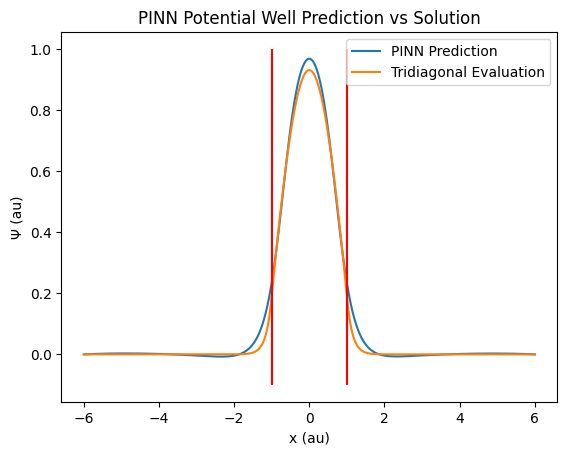

<tf.Tensor: shape=(), dtype=float32, numpy=0.0003964168718084693>

In [ ]:
x_test = np.linspace(-6, 6, 601)
#print(x_test[:, 0])
gf_test = g(x_test)
y_pred = model(x_test)
f_pred = gf_test*y_pred[:,0]
f_pred_norm = f_pred / np.sqrt(np.trapz(f_pred**2, x_test))
V_plot = V(x_test)

print(f_pred_norm.shape)


V_d = np.where(np.abs(x_test) <= l, 0.0, v0)

dx = x_test[1] - x_test[0]

main_diag = 2.0 / dx**2 + V_d[1:-1]
off_diag = -1.0 / dx**2 * np.ones(601 - 3)

eigenvalues, eigenvectors = eigh_tridiagonal(main_diag, off_diag)

E0 = eigenvalues[0]
psi0 = eigenvectors[:, 0]

print(E0)

psi0 = psi0 / np.sqrt(scipy.integrate.simpson(abs(psi0)**2, x_test[1:-1]))

psi_full = np.zeros(601)
psi_full[1:-1] = psi0

y_true = psi_full



plt.plot(x_test, f_pred)
plt.plot(x_test, y_true)
plt.title('PINN Potential Well Prediction vs Solution')
plt.legend(['PINN Prediction', 'Tridiagonal Evaluation'])
plt.vlines([-l, l], -0.1, 1, "r")
plt.xlabel("x (au)")
plt.ylabel("Ψ (au)")
plt.show()

val_error = 0

for i in range(len(f_pred)):

  val_error += (f_pred[i] - y_true[i])**2

test_error = val_error/len(f_pred)

test_error

/tmp/ipython-input-18-3004785527.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_pred_norm = f_pred / np.sqrt(np.trapz(f_pred**2, x_test))
/tmp/ipython-input-18-3004785527.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  psi0 = psi0 / np.sqrt(np.trapz(psi0**2, x_test[1:-1]))


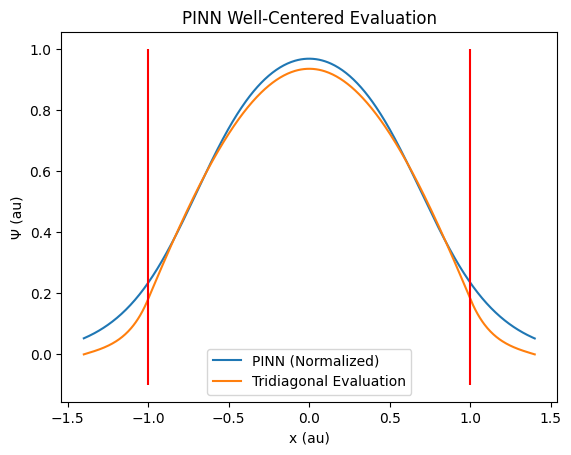

<tf.Tensor: shape=(), dtype=float32, numpy=0.0013285657623782754>

In [ ]:
x_test = np.linspace(-1.4, 1.4, 601)
#print(x_test[:, 0])
gf_test = g(x_test)
y_pred = model(x_test)
f_pred = y_pred[:,0]*gf_test
f_pred_norm = f_pred / np.sqrt(np.trapz(f_pred**2, x_test))
V_plot = V(x_test)

V_d = np.where(np.abs(x_test) <= l, 0.0, v0)

dx = x_test[1] - x_test[0]

main_diag = 2.0 / dx**2 + V_d[1:-1]
off_diag = -1.0 / dx**2 * np.ones(601 - 3)

eigenvalues, eigenvectors = eigh_tridiagonal(main_diag, off_diag)

E0 = eigenvalues[0]
psi0 = eigenvectors[:, 0]

psi0 = psi0 / np.sqrt(np.trapz(psi0**2, x_test[1:-1]))

psi_full = np.zeros(601)
psi_full[1:-1] = psi0

y_true = psi_full

plt.plot(x_test, f_pred)
plt.plot(x_test, y_true)
plt.title('PINN Well-Centered Evaluation')
plt.legend(['PINN (Normalized)', 'Tridiagonal Evaluation'])
plt.vlines([-l, l], -0.1, 1, "r")
plt.xlabel("x (au)")
plt.ylabel("Ψ (au)")
plt.show()

val_error = 0

for i in range(len(f_pred)):

  val_error += (f_pred_norm[i] - y_true[i])**2

test_error = val_error/len(f_pred)
test_error = test_error

test_error

In [ ]:
plt.semilogy(epoch_arr[:max_epoch//20+1], error_arr[:max_epoch//20+1])
plt.title('Error por Epoch')
plt.show()

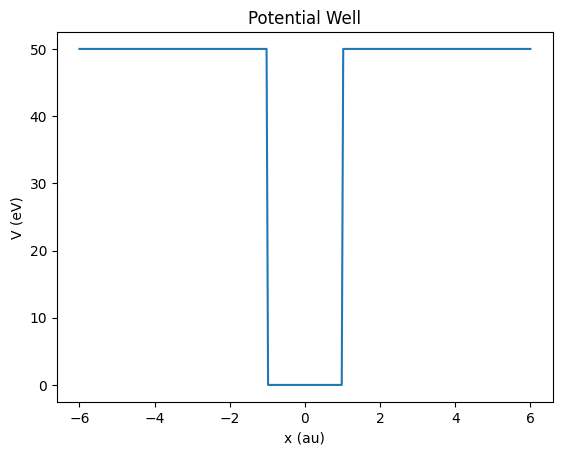

In [ ]:
x_test = np.linspace(-6*l, 6*l, 601)
plt.plot(x_test, V(x_test))
plt.title('Potential Well')
plt.xlabel("x (au)")
plt.ylabel("V (eV)")
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95 (380.00 B)

 Trainable params: 95 (380.00 B)

 Non-trainable params: 0 (0.00 B)

1.8570135450324359
Montecarlo: 1	 Starting MSE Loss = 1561.8935546875
Montecarlo: 1	 Final Epoch = 1946	 Final MSE Loss = 0.3990618586540222
Execution time of NN number 1:  229.78693413734436
(601,)
1.8570135450324359


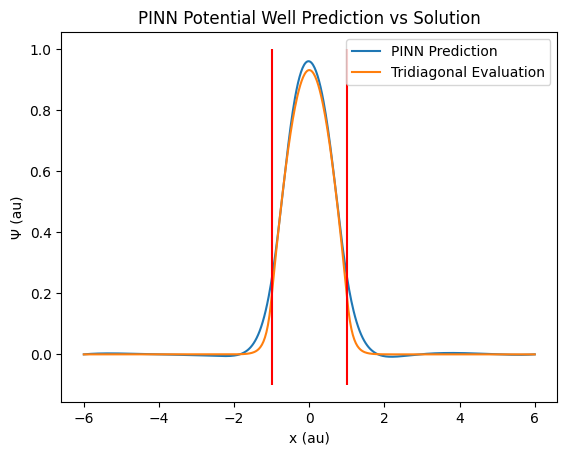

Test MSE Loss = 0.00037741323467344046

Mean starting error: 1561.8935546875         Starting error Variance: 0.0
Mean max epoch: 1946.0                Max Epoch Variance: 0.0
Mean final error: 0.3990618586540222             Final error Variance: 0.0
Mean validation error: 0.00037741323467344046         Validation error Variance: 0.0



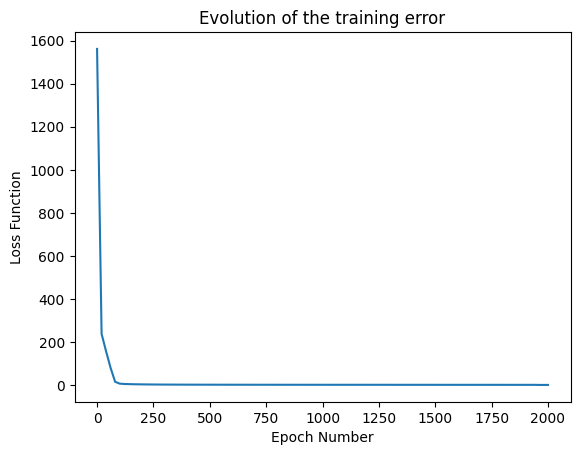

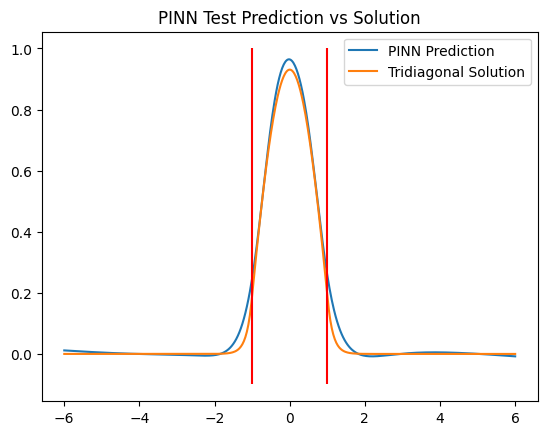

In [ ]:
import numpy as np
import scipy

def paralel_montecarlo_pinn_schrodinger(j,max_epochs=10000, seed=128):

    import os

    #Usamos el Keras 2.x, ya que es el único compatible con qml.qnn.KerasLayer

    os.environ["TF_USE_LEGACY_KERAS"] = "1"

    import numpy as np
    import tensorflow as tf
    import matplotlib.pyplot as plt
    import time
    import scipy


    #Evitamos warnings sobre el cast complex a float

    tf.get_logger().setLevel('ERROR')

    #Forzamos a Tensorflow a trabajar con "float64" (desactivado)

    #tf.keras.backend.set_floatx('float64')


    num_domain = 64
    l = 1
    minval = -6*l
    maxval = 6*l

    def generate_uniform_data(num_domain, minval, maxval):

      data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=seed)
      return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)

    def generate_uniform_simetric_data(num_domain, minval, maxval):

      data_init = tf.random_uniform_initializer(minval=minval, maxval=(maxval+minval)/2, seed=seed)
      x_left = data_init(shape=[num_domain//2, 1])
      x_left = tf.sort(x_left, axis=0)
      x_right = -1*x_left[::-1]
      x_left = tf.Variable(x_left, dtype=tf.float32)
      x_right = tf.Variable(x_right, dtype=tf.float32)
      x = tf.concat([x_left, x_right], 0)
      return x


    hbar = 1
    m = 1
    v0 = 50

    def V(x):

      Xs = x
      Vnp = (1 - np.heaviside(x+l, 0.5) + np.heaviside(x-l, 0.5))*v0
      V = tf.convert_to_tensor(Vnp, dtype=tf.float32)

      return V

    def g(x):

      Xs = x
      gnp = (1 - np.exp(-abs(Xs - minval)))*(1 - np.exp(-abs(Xs - maxval)))
      g = tf.convert_to_tensor(gnp, dtype=tf.float32)

      return g

    x = generate_uniform_simetric_data(num_domain//2, minval, maxval)
    conc_x = generate_uniform_simetric_data(num_domain//2, -l, l)
    x = tf.concat([x, conc_x], axis=0)
    x = tf.sort(x, axis=0)
    x = tf.Variable(x, dtype=tf.float32)
    #print(x)
    V_pot = V(x)




    def pde(tape1, tape2, x, y, w, b, j=0):
      dy_x = tape1.gradient(y, x)[:, j : j + 1]
      dy_xx = tape2.gradient(dy_x, x)[:, j : j + 1]
      return -(hbar**2)/(2*m) * dy_xx + (V_pot - (w+b))*y

    def bc_i(x):
      return 0

    def bc_f(x):
      return 0

    x_bc_i = tf.constant(minval, shape = [1, 1], dtype=tf.float32)
    x_bc_f = tf.constant(maxval, shape = [1, 1], dtype=tf.float32)
    x_0 = tf.constant(0, shape = [1, 1], dtype=tf.float32)


    ###

    n_inputs = 1
    n_outputs = 1
    activation = 'tanh'

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((n_inputs,)))
    model.add(tf.keras.layers.Dense(units=8, activation=activation))
    model.add(tf.keras.layers.Dense(units=4, activation=activation))
    model.add(tf.keras.layers.Dense(units=7, activation=activation))
    model.add(tf.keras.layers.Dense(units=n_outputs))

    if j==0:

      model.summary()


    epochs = max_epochs
    learning_rate = 0.02

    flag = False
    previous_mse = 0
    diff_tolerance = 0.04
    tolerance = 0.4
    max_count = 5
    count = 0

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    error_arr = np.zeros(epochs//20 + 1)

    epoch_arr = np.linspace(0, epochs, epochs//20 + 1)

    E = 1.8570135450324359
    print(E)
    w, b = E, 0



    while not flag:

      starting_time = time.time()

      for i in range(epochs + 1):
        with tf.GradientTape() as tape_model:
          with tf.GradientTape() as tape_pde:
            with tf.GradientTape() as tape_pde2:


              y = model(x, training=True)
              #w, b = model.get_weights()[0][0][0], model.get_weights()[1][0]
              bc_i_error = model(x_bc_i, training=True)[0][0] - bc_i(x_bc_i)
              bc_f_error = model(x_bc_f, training=True)[0][0] - bc_f(x_bc_f)
              pos_error = tf.reduce_mean(tf.square(tf.minimum(y, 0.0)))

              gf = g(x)

              f = y*gf

              tape_pde.watch(x)
              tape_pde2.watch(x)

              domain_error = pde(tape_pde, tape_pde2, x, f, w, b)



          domain_mse = mse = tf.math.reduce_mean(tf.math.square(domain_error), axis=0)

          loss_norm = tf.math.square(tf.tensordot(f, f, 2) / E**2 - tf.convert_to_tensor(num_domain/(maxval - minval), dtype = tf.float32))
          #norm = np.sqrt(scipy.integrate.simpson(tf.tensordot(abs(f), tf.transpose(abs(f)), 1), x[:, 0]))
          #print(np.shape(f[:, 0]), np.shape(x))
          #print(norm, np.sqrt(scipy.integrate.simpson(abs(f[:, 0])**2, x[:, 0])))
          #loss_norm = tf.math.square(tf.reduce_sum(f[:, 0] - f[:, 0]/norm))
          #loss_norm = tf.math.square(tf.math.reduce_sum(f[:, 0]*f[:, 0] - 1))
          #loss_eigen = tf.convert_to_tensor(np.exp(abs(-(w+b) + E)), dtype = tf.float32) - 1
          loss_sim = tf.math.reduce_mean(tf.math.exp(tf.math.square(f[:len(f)//2 , 0] - f[len(f)//2:,0][::-1])) - 1)
          bc_i_mse =  tf.math.square(bc_i_error)
          bc_f_mse =  tf.math.square(bc_f_error)

          total_mse = domain_mse + 20*loss_norm + 20*bc_i_mse + 20*bc_f_mse + 20*loss_sim
          total_mse += (200*pos_error)**2
          #total_mse += loss_eigen


          #if i % 100 == 0:
            #print('Epoch: {}\t MSE Loss = {}'.format(i, total_mse.numpy()[0]))
            #print('Domain Loss {}'.format(domain_mse.numpy()[0]))
            #print('Boundary Loss {}'.format(20*bc_i_mse + 20*bc_f_mse))
            #print('Normalization Loss {}'.format(20*loss_norm))
            #print('Eigenvalue Loss {}'.format(loss_eigen))
            #print('Simetry Loss {}'.format(20*loss_sim))
            #print('Positive Error {}'.format((200*pos_error)**2))

          if i % 20 == 0:

            error_arr[i//20] = total_mse.numpy()[0]

          if i == 0:

            first_error = total_mse.numpy()[0]

            print('Montecarlo: {}\t Starting MSE Loss = {}'.format(j+1, first_error), flush=True)




        if abs(total_mse - previous_mse) < diff_tolerance and total_mse < tolerance:

          count += 1

          if count >= max_count:

            max_epoch = i
            last_error = total_mse.numpy()[0]


            print('Montecarlo: {}\t Final Epoch = {}\t Final MSE Loss = {}'.format(j+1, max_epoch, last_error), flush=True)

            flag = True
            break


        else:

          count = 0

        if i == epochs:

          max_epoch = i
          last_error = total_mse.numpy()[0]


          print('Montecarlo: {}\t Final Epoch = {}\t Final MSE Loss = {}'.format(j+1, max_epoch, last_error), flush=True)

          flag = True
          break

        previous_mse = total_mse

        model_update_gradients = tape_model.gradient(total_mse, model.trainable_variables)
        optimizer.apply_gradients(
        zip(model_update_gradients, model.trainable_variables)
        )

      ending_time = time.time()

      print(f"Execution time of NN number {j+1}: ", ending_time-starting_time, flush=True)

      x_test = np.linspace(minval, maxval, 601)
      #print(x_test[:, 0])
      gf_test = g(x_test)
      y_pred = model(x_test)
      f_pred = gf_test*y_pred[:,0]
      f_pred_norm = f_pred / np.sqrt(scipy.integrate.simpson(f_pred**2, x_test))
      V_plot = V(x_test)

      print(f_pred_norm.shape)


      V_d = np.where(np.abs(x_test) <= l, 0.0, v0)

      dx = x_test[1] - x_test[0]

      main_diag = 2.0 / dx**2 + V_d[1:-1]
      off_diag = -1.0 / dx**2 * np.ones(601 - 3)

      eigenvalues, eigenvectors = eigh_tridiagonal(main_diag, off_diag)

      E0 = eigenvalues[0]
      psi0 = eigenvectors[:, 0]

      print(E0)

      psi0 = psi0 / np.sqrt(scipy.integrate.simpson(abs(psi0)**2, x_test[1:-1]))

      psi_full = np.zeros(601)
      psi_full[1:-1] = psi0

      y_true = psi_full

      if j == 0:

        plt.plot(x_test, f_pred)
        plt.plot(x_test, y_true)
        plt.title('PINN Potential Well Prediction vs Solution')
        plt.legend(['PINN Prediction', 'Tridiagonal Evaluation'])
        plt.vlines([-l, l], -0.1, 1, "r")
        plt.xlabel("x (au)")
        plt.ylabel("Ψ (au)")
        plt.show()

      val_error = 0

      for i in range(len(f_pred_norm)):

        val_error += (f_pred_norm[i] - y_true[i])**2

      val_error = val_error/len(f_pred)
      val_error = val_error



      print('Test MSE Loss = {}'.format(val_error), flush=True)





    return error_arr, epoch_arr, [first_error, max_epoch, last_error, val_error], y_pred, y_true

first_error_arr = []
max_epoch_arr = []
last_error_arr = []
val_error_arr = []

for j in range(1):

  results = paralel_montecarlo_pinn_schrodinger(j,max_epochs=2000, seed=128)

  first_error_arr.append(results[2][0]), max_epoch_arr.append(results[2][1]), last_error_arr.append(results[2][2]), val_error_arr.append(results[2][3])

  if j==0:

    error_arr = results[0]
    epoch_arr = results[1]
    y_pred = results[3]
    y_true = results[4]

l=1

print(f"""
Mean starting error: {np.array(first_error_arr).mean()}         Starting error Variance: {np.array(first_error_arr).var()}
Mean max epoch: {np.array(max_epoch_arr).mean()}                Max Epoch Variance: {np.array(max_epoch_arr).var()}
Mean final error: {np.array(last_error_arr).mean()}             Final error Variance: {np.array(last_error_arr).var()}
Mean validation error: {np.array(val_error_arr).mean()}         Validation error Variance: {np.array(val_error_arr).var()}
""")

plt.plot(epoch_arr, error_arr)
plt.title("Evolution of the training error")
plt.xlabel("Epoch Number")
plt.ylabel("Loss Function")
plt.show()

x_test = np.linspace(-6, 6, 601)

plt.plot(x_test, y_pred)
plt.plot(x_test, y_true)
plt.title("PINN Test Prediction vs Solution")
plt.legend(["PINN Prediction", "Tridiagonal Solution"])
plt.vlines([-l, l], -0.1, 1, "r")
plt.show()

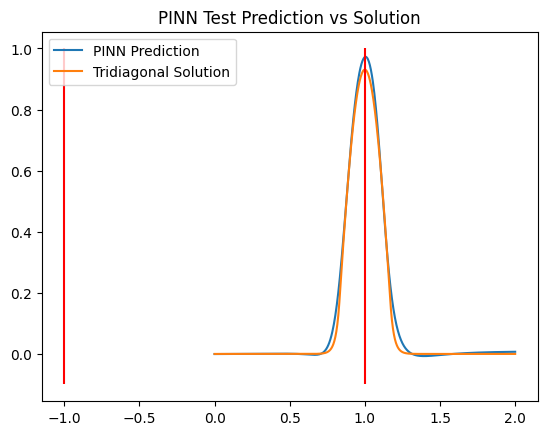

In [ ]:
plt.plot(x_test, y_pred)
plt.plot(x_test, y_kutta)
plt.title("PINN Test Prediction vs Solution")
plt.legend(["PINN Prediction", "Tridiagonal Solution"])
plt.vlines([-1, 1], -0.1, 1, "r")
plt.show()